In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from scipy import ndimage as ndi

from skimage import (
    exposure, io, morphology, color, feature, filters, util, segmentation
)
import math
#import napari
#from napari.utils import nbscreenshot
from scipy import signal
from skimage.filters import threshold_multiotsu
from skimage.filters import try_all_threshold, gaussian
from skimage.morphology import disk
from skimage.filters import threshold_li
from skimage import measure
import pandas as pd
import os
#import PyDIP as dip
import math
import re
from glob import glob
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.segmentation import random_walker, clear_border
from scipy import ndimage
from skimage.measure import label, regionprops, regionprops_table
from skimage.exposure import histogram

In [6]:
def slice(im3d):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen=[]
    for i in range(stack_size):
        if hist[i] >= (ups['peak_heights'][0]+2*ups2['peak_heights'][0])/3:
            plt.vlines(i,0,max(hist), colors='y')
            chosen.append(i)
    return chosen

In [7]:
def slice_manual(im3d,start,stop):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen = range(start,stop)
    for i in chosen:
        plt.vlines(i,0,max(hist), colors='y')
    return chosen

In [8]:
def display(im3d, cmap="gray", step=1, chosen = None):
    if chosen is None: 
        chosen = []
    stack_size = im3d.shape[0]
    cols = 5
    rows = math.ceil((stack_size/cols))
    
    h , axes = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols, 3*rows))
    #print(h)
    #p1 = get(h,'Position')
    #annotation('rectangle',p1,'FaceAlpha',.2,'FaceColor','red','EdgeColor','red') 
    vmin = im3d.min()
    vmax = im3d.max()
    enum = 0
    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        if enum in chosen:
            for axis in ['top','bottom','left','right']:
                #ax.spines[axis].set_linewidth(0.5)
                ax.spines[axis].set_color("red")
                ax.spines[axis].set_linewidth(5)
        ax.set_xticks([])
        ax.set_yticks([])
        enum += 1
    #plt.savefig('foo.png')
    

In [9]:
def display_slice(im, cmap="gray", step=1, chosen = None, savefig = False):
    h , axes = plt.subplots(1,1)
    vmin = im.min()
    vmax = im.max()
    enum = 0
    axes.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)

In [10]:
ResultsDir = "/groups/gerlich/labinfo/Papers/2023_Batty_et_al/fig_by_fig_description/appendix_figures/appendix_figures_s4/panel_j/output/"

In [11]:
#Define function to threshold a field of cells using MultiOtsu thresholding from skimage
#apply watershedding and then extract features >>> final output is a dataframe

#To do >>> extract metadata automatically using TIFFFILE

In [12]:
def image_stdev(region, intensities):
    # note the ddof arg to get the sample var if you so desire!
    return np.std(intensities[region], ddof=1)

In [13]:
#background subtraction - mean fluorescence in background of three cells drawn, divided by three to subtract from the mean fluorescence of each channel

#for the Halo TMR background fluorescence, WT cells were stained with Halo-TMR at the same time as SMC4. The Halo TMR fluorescence in the nuclei 
# of WT cells was then measured to correct for background >>> 6 cells from 3 images
#1802 minus auxin - Hoechst, 0.120, 0.133, 0.115 >>> 0.123
#mean nuclear Halo fluorescence is 5.87 in wt cells






In [14]:
pixel_size = (14.1681)
#this is the number of pixels per micron, change the pixel size according to your specific image
scaling_factor = pixel_size**2




def threshold_field(images):
    
    #Set up variables as empty dataframes
    all_hoechst = pd.DataFrame()
    all_scc1 = pd.DataFrame()
    all_wapl = pd.DataFrame()

    #read in files
    for image in images:
        data = io.imread(image)
        #select channels, wapl = channel3, Scc1 = channel2, Hoechst = channel 1 in this image
        hoechst = data[:,:,0]
        scc1 = data[:,:,1]
        wapl = data[:,:,2]
        #display_slice(wapl)
        
        #subtract background values
        
        #hoechst = hoechst - 0.123
        #scc1 = scc1 - 7.405
        
        
        sigma = 1.0

        # apply Gaussian blur, creating a new image
        blurred = filters.gaussian(
        hoechst, sigma=(sigma, sigma), truncate=3.5, multichannel=True)
        #display_slice(blurred)


        #threshold the hoechst_channel using multiotsu thresholding
        thresh = threshold_li(blurred)
        #mask = hoechst > thresh
        
        binary_mask = morphology.binary_closing(blurred > thresh, disk(8)) 
        
        #binary_mask = ndimage.binary_fill_holes(blurred).astype(int)
        
        cleared = clear_border(binary_mask)
        remove_debris = morphology.remove_small_objects(cleared, 25000)
        

        #optimise thresholding parameters for this dataset

        #igher_threshold = 60
        #ilt = hoechst > higher_threshold

        #moother_filt = filters.rank.mean(util.img_as_ubyte(remove_debris),
                                      #orphology.disk(4))

        #inal_thresh = smoother_filt > 60

        #apply watershedding to distinguish cells which are thresholded as a single cell when in reality there are two
        distance = ndi.distance_transform_edt(remove_debris)

        local_max_coords = feature.peak_local_max(distance, min_distance=50)
        local_max_mask = np.zeros(distance.shape, dtype=bool)
        local_max_mask[tuple(local_max_coords.T)] = True
        markers = measure.label(local_max_mask)

        segmented_cells = segmentation.watershed(-distance, markers, mask=remove_debris)
        
        remove_small_masks = morphology.remove_small_objects(segmented_cells, 15000)
        
        segmented_cells = remove_small_masks

        #this is the number of pixels per micron, change the pixel size according to your specific image
        #Generate labels, each thresholded object becomes a label
        pixel_size = (14.1681)
        scaling_factor = pixel_size**2

        #Generate labels, each thresholded object becomes a label
        labels = measure.label(segmented_cells)
        properties = measure.regionprops(labels)

        #choose which features to extract and extract features for the first channel. Calculate nuclear area

        properties_hoechst = ["area", "mean_intensity"]
        output_hoechst = pd.DataFrame(regionprops_table(labels, hoechst, 
             properties=properties_hoechst))
        #rename columns
        output_hoechst = output_hoechst.rename(columns={"area":"area_pixels"})
        output_hoechst = output_hoechst.rename(columns={"mean_intensity":"mean_hoechst"})

        #get nuclear area in microns instead of pixels and then calculate total intensity per nucleus
        output_hoechst["nuclear_area_microns"] = output_hoechst["area_pixels"]/scaling_factor
        #calculate total intensity 
        output_hoechst["total_hoechst"] = output_hoechst["nuclear_area_microns"] * output_hoechst["mean_hoechst"]

        #extract info for second channel, area is the same as for the first channel
        properties_scc1 = ["mean_intensity"]
        #extra_properties = ["image_stdev"]
        output_scc1 = pd.DataFrame(regionprops_table(labels, scc1, 
             properties=properties_scc1))
        output_scc1 = output_scc1.rename(columns={"mean_intensity":"mean_scc1"})
        #output_scc1 = output_scc1.rename(columns={"image_stdev":"std_scc1"})
        output_scc1["total_nuclear_scc1"] = output_hoechst["nuclear_area_microns"] * output_scc1["mean_scc1"]

        props_hoechst = pd.DataFrame(regionprops_table(labels, hoechst, extra_properties=[image_stdev]))
        
        output_hoechst["std_hoechst"] = props_hoechst["image_stdev"]       
        
        props_scc1 = pd.DataFrame(regionprops_table(labels, scc1, extra_properties=[image_stdev]))
        
        output_scc1["std_scc1"] = props_scc1["image_stdev"]
        
        #extract info for second channel, area is the same as for the first channel
        properties_wapl = ["mean_intensity"]
        output_wapl = pd.DataFrame(regionprops_table(labels, wapl, 
             properties=properties_wapl))
        output_wapl = output_wapl.rename(columns={"mean_intensity":"mean_wapl"})
        output_wapl["total_nuclear_wapl"] = output_hoechst["nuclear_area_microns"] * output_wapl["mean_wapl"]
        
        
        #for i in range(len(properties)):
            #print(properties[i].area)
        
        #Display thresholding to check if it is appropriate
        #display_slice(hoechst)
        #display_slice(final_thresh)
        #display_slice(segmented_cells)
        image_name = image
        print(image_name)
        fig, ax = plt.subplots(ncols=4, figsize=(25, 5))
        ax[0].imshow(hoechst, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')
        ax[1].imshow(blurred, cmap='gray')
        ax[1].set_title('Blurred Image')
        ax[1].axis('off')
        ax[2].imshow(remove_debris, cmap='gray')
        ax[2].set_title('Threshold binary mask')
        ax[2].axis('off')
        ax[3].imshow(color.label2rgb(segmented_cells, bg_label=0))
        ax[3].set_title('Segmented nuclei after watershedding')
        ax[3].axis('off')
        plt.show()

        all_hoechst = all_hoechst.append(output_hoechst)
        all_scc1 = all_scc1.append(output_scc1)
        all_wapl = all_wapl.append(output_wapl)
        
        #print(output_hoechst)
        #print(output_scc1)
        #print(all_hoechst)
        #print(all_scc1)
        all_data = pd.concat([all_hoechst, all_scc1, all_wapl], axis=1)
        all_data["image_name"] = image_name
        #print(all_data)
    
    #reorder columns for final output
    final_df = all_data[["nuclear_area_microns", "mean_hoechst", "mean_scc1", "mean_wapl", "total_hoechst", "total_nuclear_scc1", "total_nuclear_wapl", "std_hoechst", "std_scc1"]]
    final_df = final_df.loc[(final_df.nuclear_area_microns > 100)]
    #final_df = final_df.loc[(final_df.mean_wapl <)]
    
    final_df["coeff_variance_hoechst"] = final_df["std_hoechst"]/final_df["mean_hoechst"]
    final_df["coeff_variance_scc1"] = final_df["std_scc1"]/final_df["mean_scc1"]
    final_df["condition"] = "1802_minus_aux"

    #output final dataframe to the results directory
    #final_df.to_csv(os.path.join(ResultsDir + "test.csv"), index = False)
    final_df.to_csv(os.path.join(ResultsDir + "1802_minus_aux_fields.csv"), index = False)
    return final_df


/tmp/ipykernel_75373/133900367.py:33: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0.Please use `channel_axis` instead.
  blurred = filters.gaussian(
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1802_minus_aux_stain_hoechst_scc1_halo-wapl-tmr_pos1-13 #07.tif


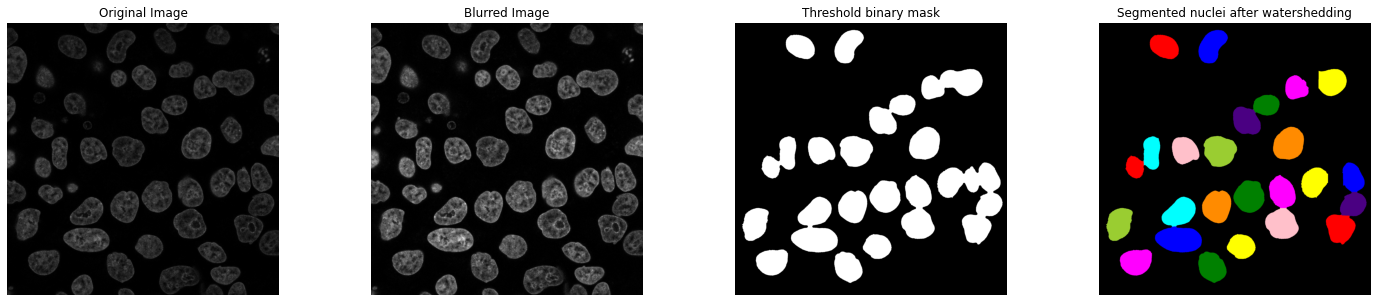

1802_minus_aux_stain_hoechst_scc1_halo-wapl-tmr_pos1-13 #08.tif


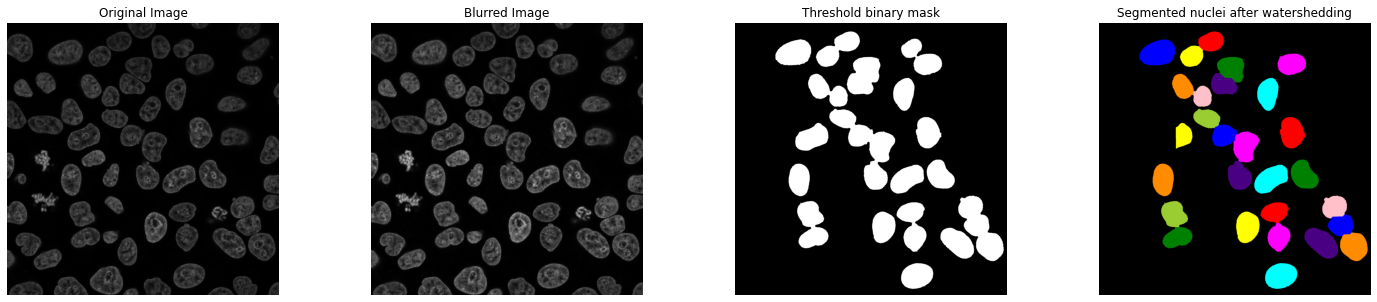

1802_minus_aux_stain_hoechst_scc1_halo-wapl-tmr_pos1-13 #09.tif


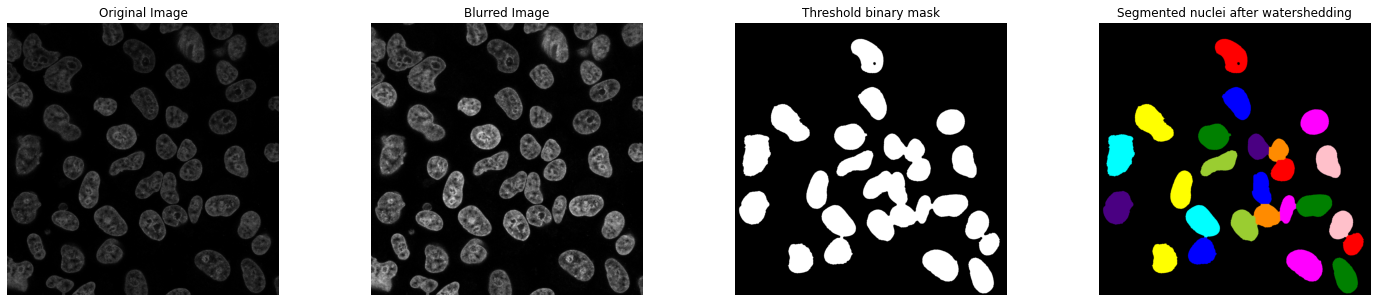

1802_minus_aux_stain_hoechst_scc1_halo-wapl-tmr_pos1-13 #10.tif


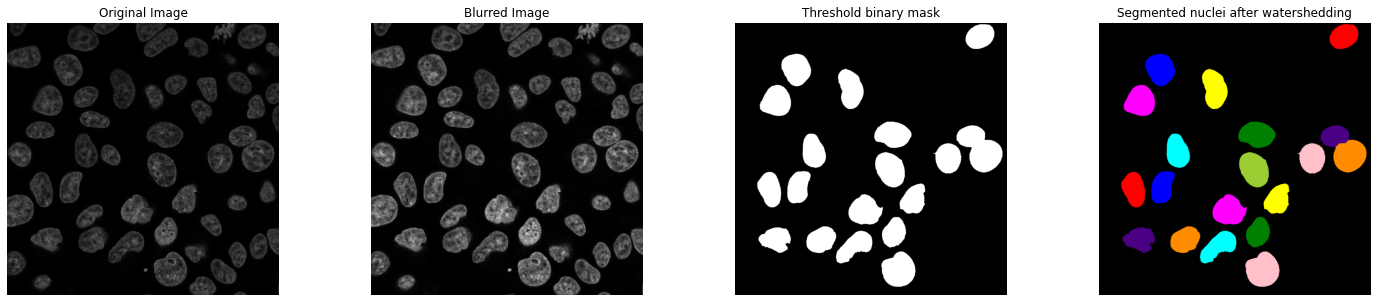

1802_minus_aux_stain_hoechst_scc1_halo-wapl-tmr_pos1-13 #11.tif


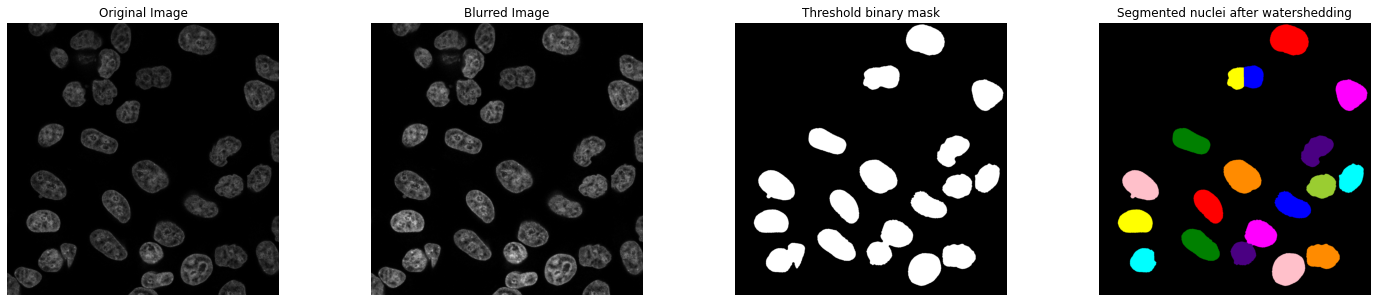

1802_minus_aux_stain_hoechst_scc1_halo-wapl-tmr_pos1-13 #12.tif


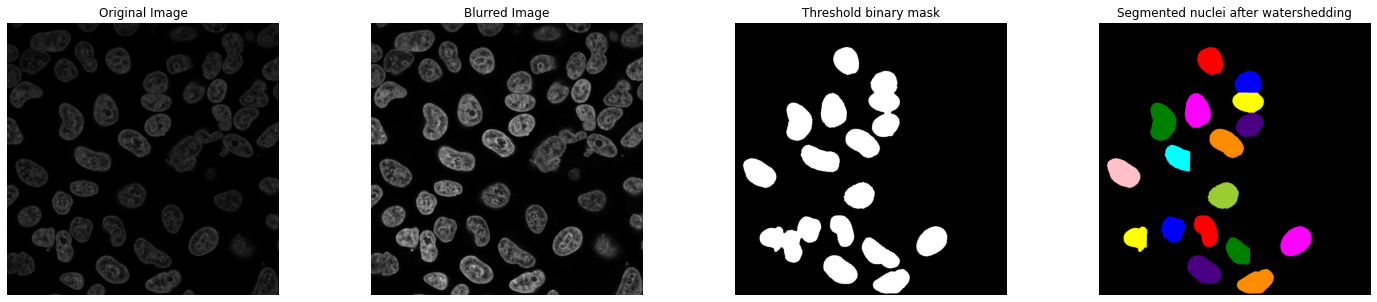

1802_minus_aux_stain_hoechst_scc1_halo-wapl-tmr_pos1-13 #13.tif


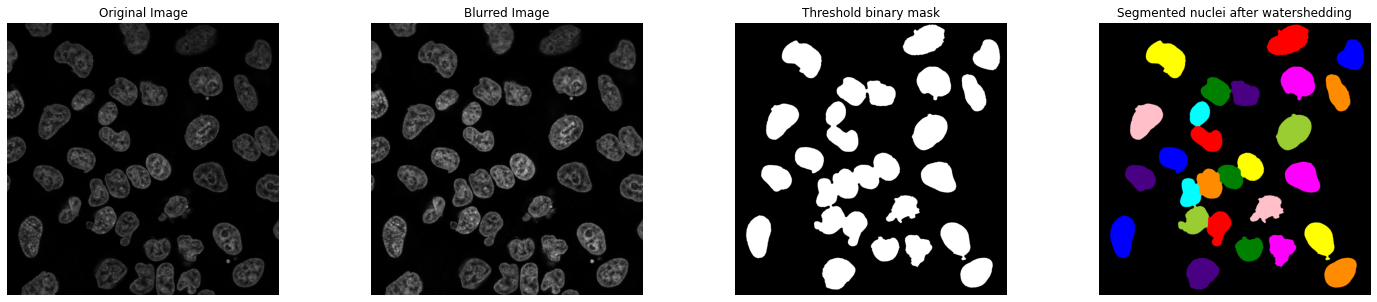

1802_minus_aux_stain_hoechst_scc1_halo-wapl-tmr_pos1-13 #01.tif


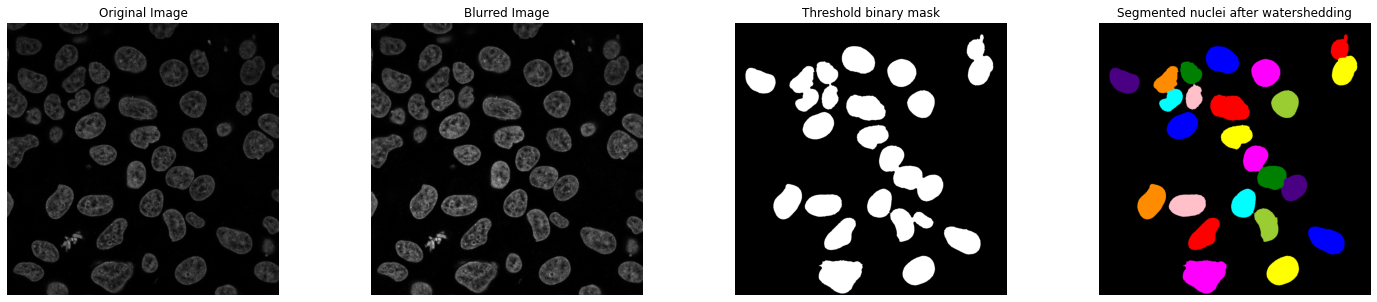

1802_minus_aux_stain_hoechst_scc1_halo-wapl-tmr_pos1-13 #02.tif


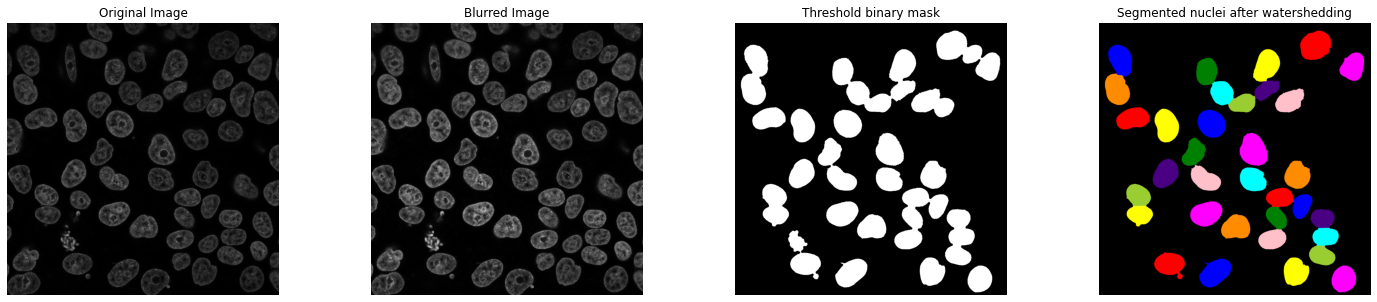

1802_minus_aux_stain_hoechst_scc1_halo-wapl-tmr_pos1-13 #03.tif


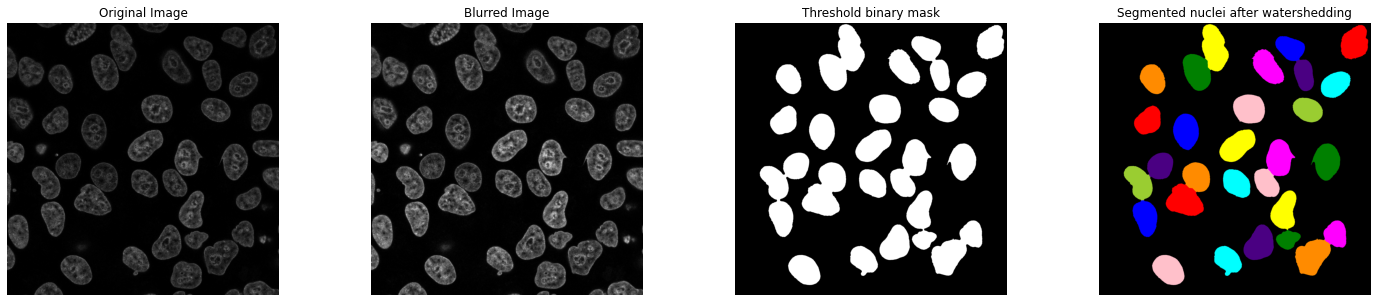

1802_minus_aux_stain_hoechst_scc1_halo-wapl-tmr_pos1-13 #04.tif


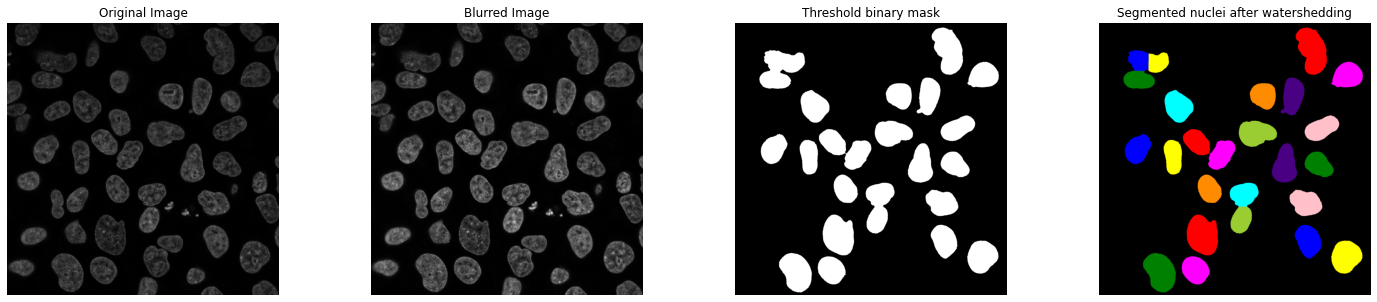

1802_minus_aux_stain_hoechst_scc1_halo-wapl-tmr_pos1-13 #05.tif


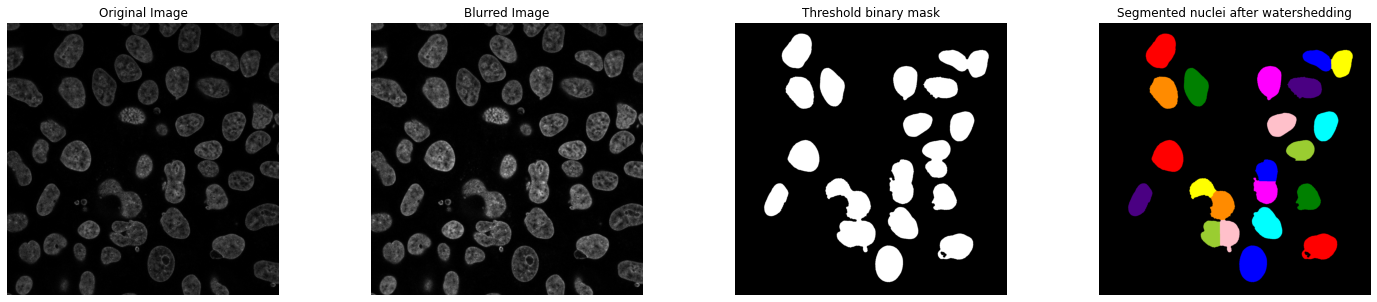

1802_minus_aux_stain_hoechst_scc1_halo-wapl-tmr_pos1-13 #06.tif


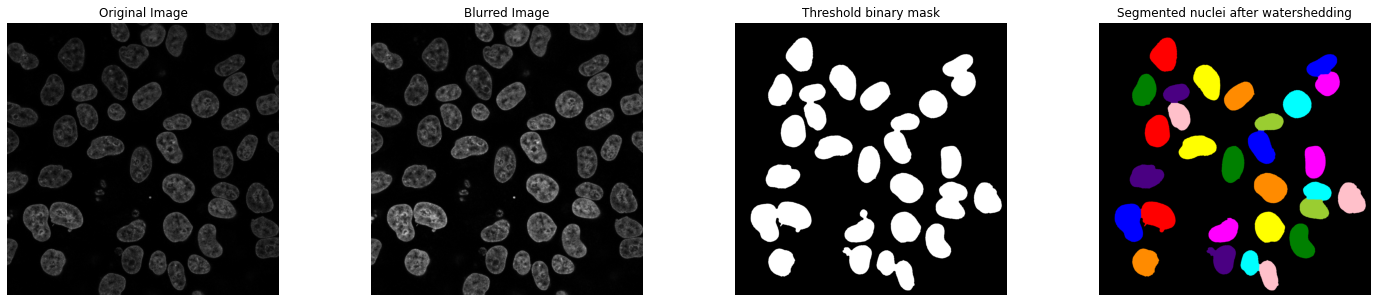

1802_minis_auxin_stain_hoechst_scc1_halo-wapl-tmr_pos14-31 #04.tif


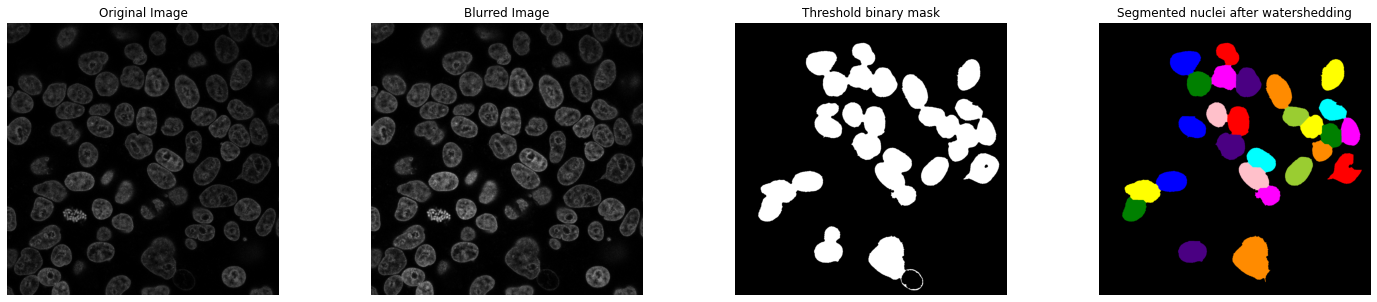

1802_minis_auxin_stain_hoechst_scc1_halo-wapl-tmr_pos14-31 #05.tif


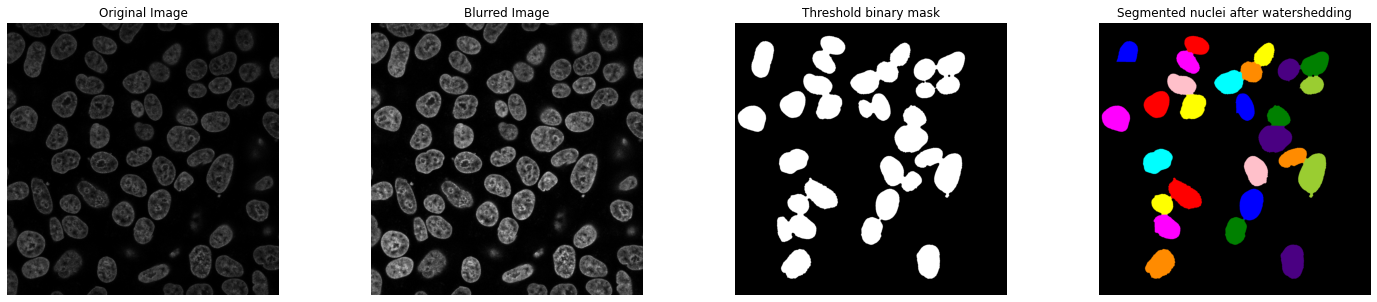

1802_minis_auxin_stain_hoechst_scc1_halo-wapl-tmr_pos14-31 #06.tif


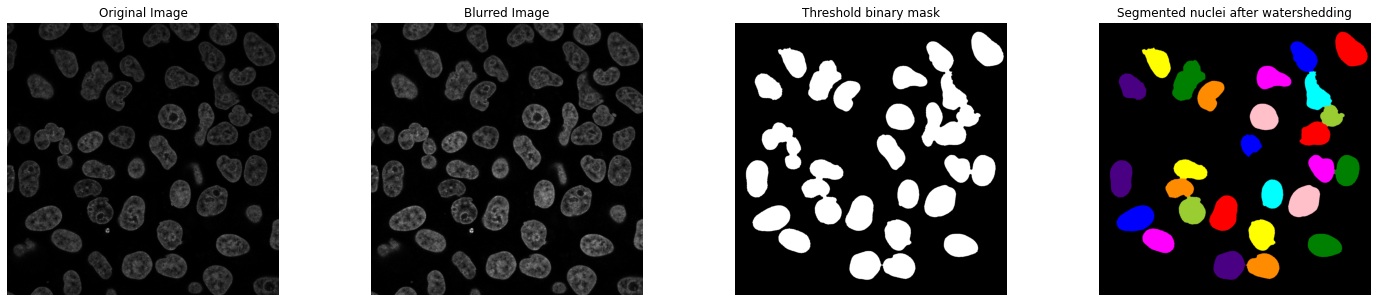

1802_minis_auxin_stain_hoechst_scc1_halo-wapl-tmr_pos14-31 #07.tif


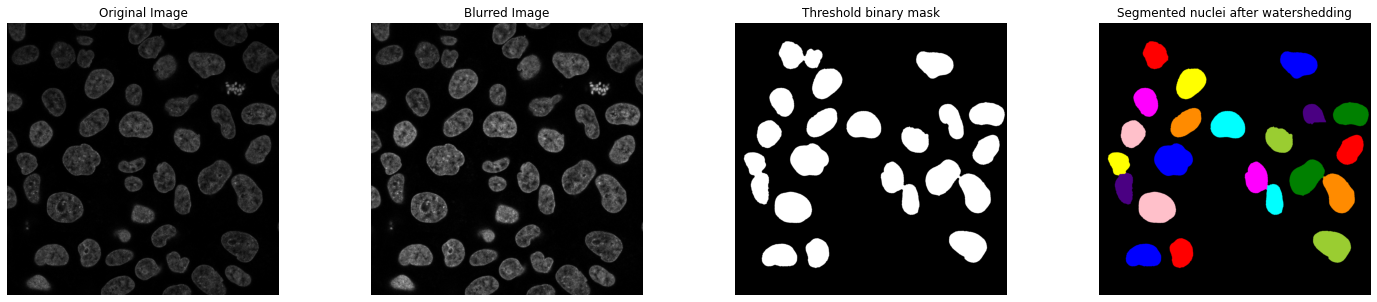

1802_minis_auxin_stain_hoechst_scc1_halo-wapl-tmr_pos14-31 #09.tif


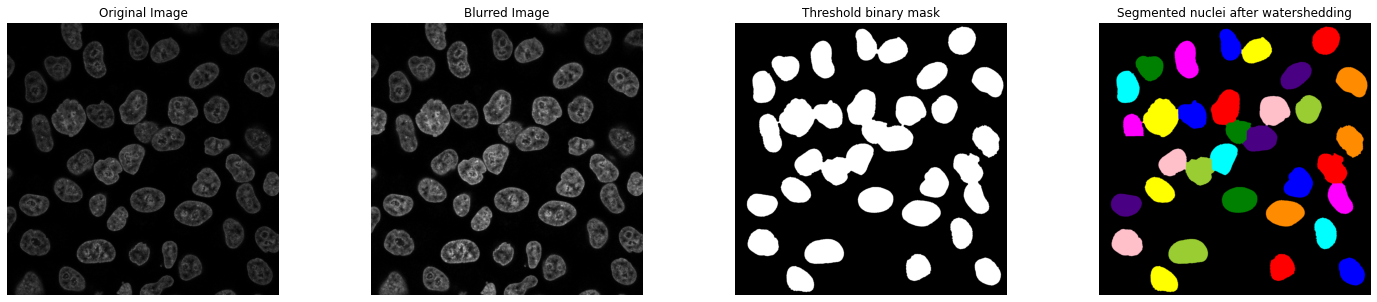

1802_minis_auxin_stain_hoechst_scc1_halo-wapl-tmr_pos14-31 #10.tif


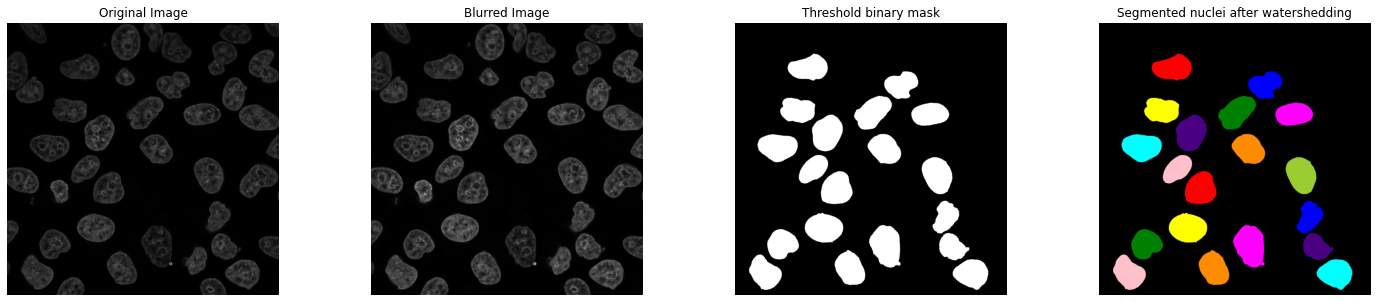

1802_minis_auxin_stain_hoechst_scc1_halo-wapl-tmr_pos14-31 #11.tif


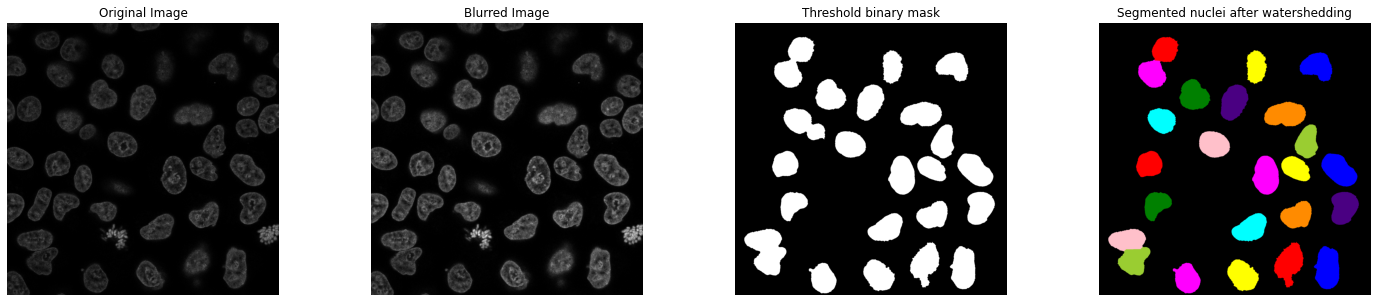

1802_minis_auxin_stain_hoechst_scc1_halo-wapl-tmr_pos14-31 #12.tif


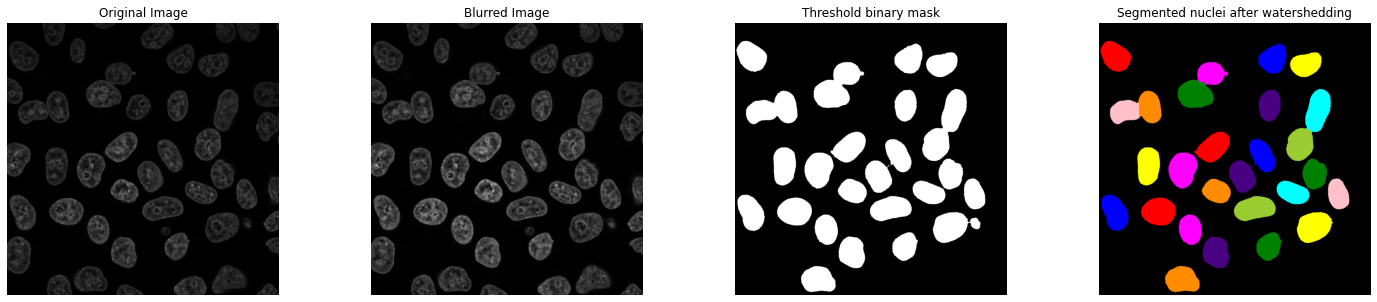

1802_minus_auxin_stain_hoechst_scc1_halo-wapl-tmr_pos14-31.czi - 1802_minis_auxin_stain_hoechst_scc1_halo-wapl-tmr_pos14-31 #13.tif


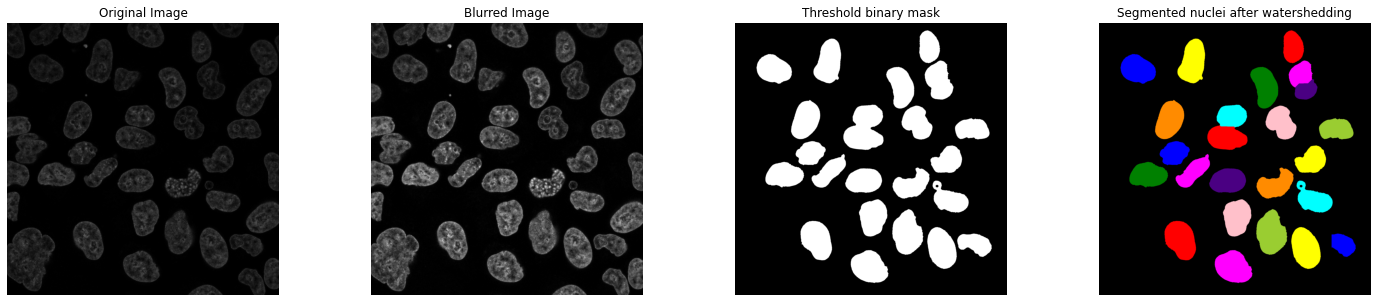

1802_minis_auxin_stain_hoechst_scc1_halo-wapl-tmr_pos14-31 #01.tif


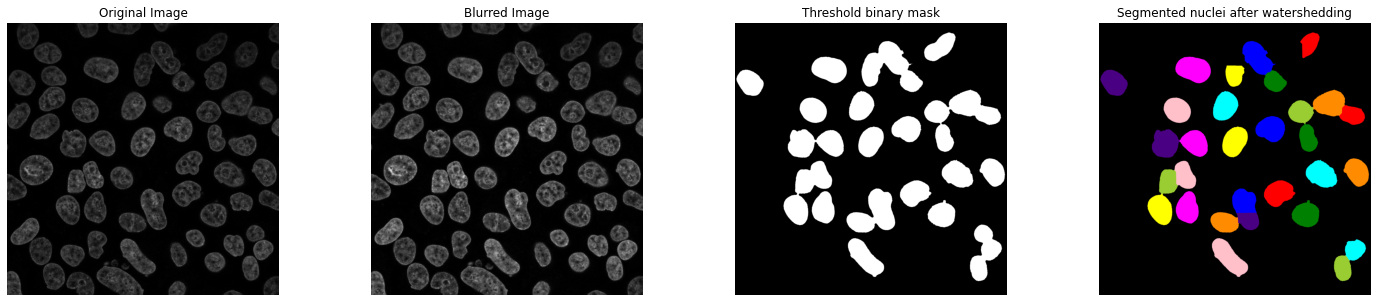

1802_minis_auxin_stain_hoechst_scc1_halo-wapl-tmr_pos14-31 #02.tif


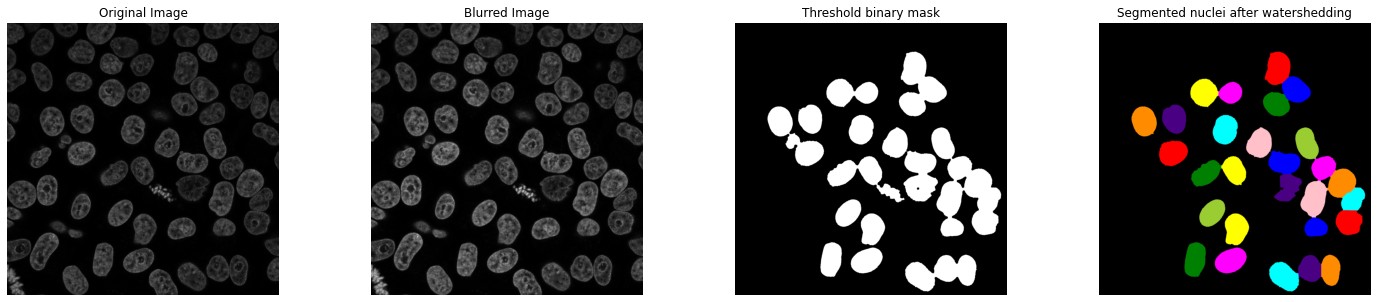

1802_minis_auxin_stain_hoechst_scc1_halo-wapl-tmr_pos14-31 #16.tif


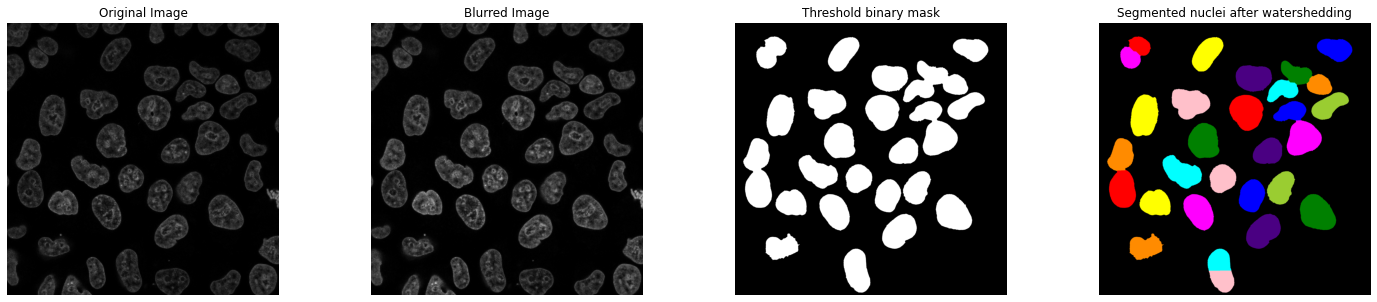

1802_minis_auxin_stain_hoechst_scc1_halo-wapl-tmr_pos14-31 #17.tif


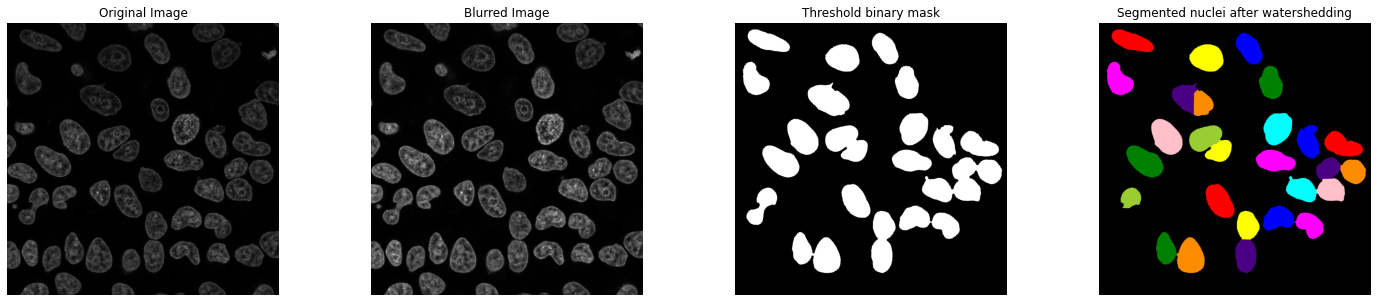

1802_minis_auxin_stain_hoechst_scc1_halo-wapl-tmr_pos14-31 #18.tif


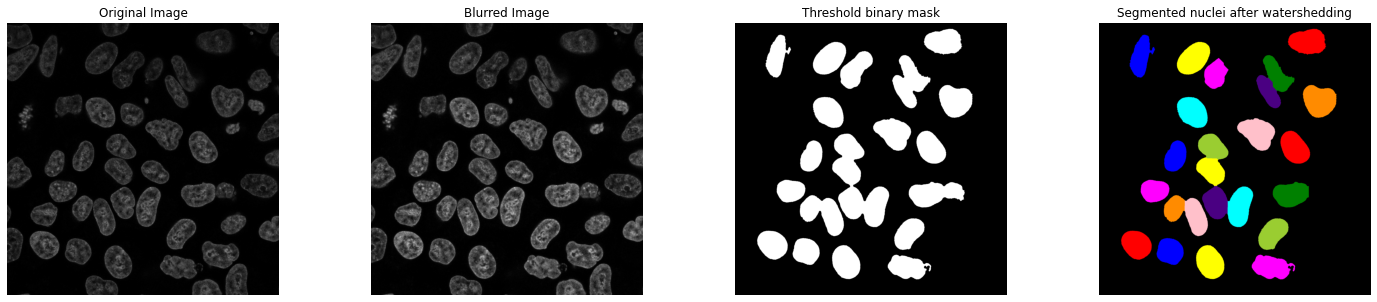

1802_minis_auxin_stain_hoechst_scc1_halo-wapl-tmr_pos14-31 #15.tif


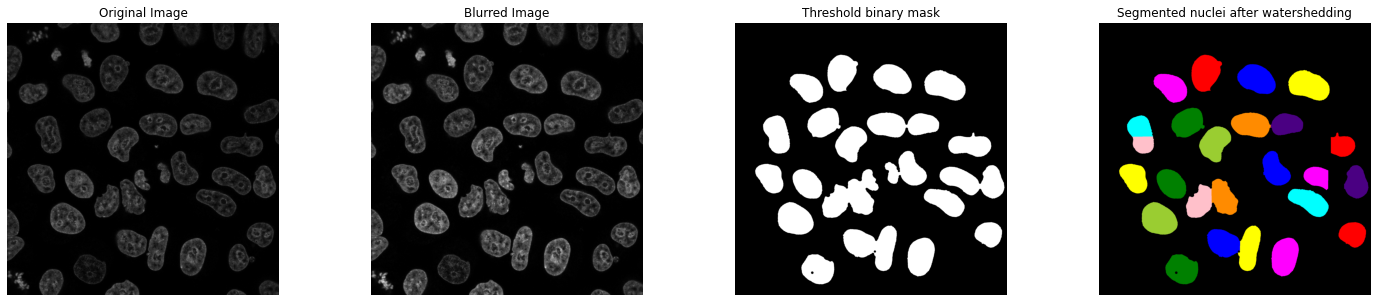

In [15]:
inpath = ("/groups/gerlich/experiments/Experiments_005600/005606/images/tifs/attempt1_220808/1802_minus_auxin/")
os.chdir(inpath)
images = glob('*.tif', recursive=True)
result = threshold_field(images)

#data = io.imread("/groups/gerlich/experiments/Experiments_005200/005223/Images/Projections/short_g2_scc1_smc4/2108_zoom5_0_control_short_G2_cycB1_SMC4_Scc1_EGFP_Hoechst-02-64.czi #1.tif_registered.tif")

In [16]:
result

nuclear_area_microns  mean_hoechst  mean_scc1  mean_wapl  total_hoechst  \
0             159.244730     17.021398  39.333511  16.863198    2710.567882   
1             132.866677     15.739680  39.069664  23.842113    2091.278947   
2             152.589191     20.698204  34.140581  17.032876    3158.322256   
3             105.920711     24.003998  47.316997  18.252140    2542.520505   
4             107.121298     24.327908  45.406780  19.679859    2606.037063   
..                   ...           ...        ...        ...            ...   
20            128.926159     20.494822  46.593624  13.056762    2642.318718   
21            180.312300     28.437851  36.817599  14.582788    5127.694247   
22            173.905846     24.750408  40.759661  14.155003    4304.240676   
23            203.038774     28.205265  36.657041  21.884560    5726.762498   
24            182.035965     11.159136  41.151091  26.211817    2031.364152   

    total_nuclear_scc1  total_nuclear_wapl  std_hoechst   std_scc1  \
0          6263.654266         2685.375472     9.503408  25.830109   
1          5191.056373         3167.822340     8.705643  25.376668   
2          5209.483647         2599.032806    10.605041  23.686733   
3          5011.850008         1933.279640    11.979178  30.187187   
4          4864.033277         2108.132008    12.523866  29.110081   
..                 ...                 ...          ...        ...   
20         6007.137041         1683.358174    12.001239  29.472979   
21         6638.665990         2629.455992    14.375936  24.570233   
22         7088.343297         2461.637772    13.494982  27.521204   
23         7442.800564         4443.414173    14.846252  24.022139   
24         7490.978496         4771.493387     7.988606  26.165269   

    coeff_variance_hoechst  coeff_variance_scc1       condition  
0                 0.558321             0.656695  1802_minus_aux  
1                 0.553102             0.649524  1802_minus_aux  
2                 0.512365             0.693800  1802_minus_aux  
3                 0.499049             0.637978  1802_minus_aux  
4                 0.514794             0.641095  1802_minus_aux  
..                     ...                  ...             ...  
20                0.585574             0.632554  1802_minus_aux  
21                0.505521             0.667350  1802_minus_aux  
22                0.545243             0.675207  1802_minus_aux  
23                0.526365             0.655321  1802_minus_aux  
24                0.715880             0.635834  1802_minus_aux  

[640 rows x 12 columns]

In [24]:
# Testing thresholding on single image using cellpose and napari

# To do, use command line and cell pose to apply thresholding to a folder of cells

In [25]:
data = io.imread("/groups/gerlich/experiments/Experiments_005600/005606/images/tifs/2096_minus_dtag/2096_minus_dtag_stain_hoechst_scc1_pos1-6 #06.tif")
#mask = io.imread("/groups/gerlich/experiments/Experiments_005000/005003/TIFs_registered_background_subtracted_testing/WT_fully_noR/Rep1/1/slices/20/Mask.tif")
print("shape: {}".format(data.shape))
print("dtype: {}".format(data.dtype))
print("range: ({}, {})".format(data.min(), data.max()))

#print("m shape: {}".format(mask.shape))
#print("m dtype: {}".format(mask.dtype))
#print("m range: ({}, {})".format(mask.min(), mask.max()))

FileNotFoundError: [Errno 2] No such file or directory: '/groups/gerlich/experiments/Experiments_005600/005606/images/tifs/2096_minus_dtag/2096_minus_dtag_stain_hoechst_scc1_pos1-6 #06.tif'

In [ ]:
hoechst = data[0,:,:]
scc1 = data[1,:,:]
#wapl_ha = data[:,:,2]
display_slice(hoechst)
